# Convolutional Neural Networks (CNN) and Deep Architectures

In these practicals, we will create a first convolutional neural network (CNN). This type of networks mostly rely on alternating layers of convolution and pooling. A convolution layer is a signal processing inspired layer that performs a bunch of convolutions on the layer input and yields filtered outputs known as feature maps. A pooling layer is a sort of subsampling layer. Most of the time, after several Conv/Pool layer pairs, an MLP is plugged to obtain class membership probabilities. When the number of layers is rather high (unclear how high this is), we obtain a deep network.

We will use `TensorFlow v2.O` (or higher) as programming framework and build a CNN to solve an image classification task.

## Starting with TensorFlow

`TensorFlow` is Google's library designed to create and train deep nets. It relies on an underlying computation graph. Each node of this graph performs an operation on an input tensor. The possible number of ops is very large (ranging from addition, dot product and more complex non-linear operations). The input tensor of the network will flow through these nodes, hence the name of the library. 

Here is an example of computation graph:

<img src="graph.png" alt="drawing" width="200"/>

This graph is a tree whose final node output correponds to the following function :

$$f\left( x,y\right) = x^2 + 2y,$$

for some $x$ and $y$. 
To implement this tree in `TensorFlow`, each node will be an instance of the `Tensor` class. 
Let us start with the inputs of function $f$ and suppose, we are interested in evaluation function $f$ for the following three pairs $(x,y)$:
* $(x,y) = (1,2)$
* $(x,y) = (2,3)$
* $(x,y) = (3,4)$

Starting with $x$, we shall define a tensor containing the successive values of this input : 
```python
x = tf.constant([1,2,3])
type(x)
```
The console answers that `x` has type `<class 'tensorflow.python.framework.ops.EagerTensor'>`. Let us forget about the "eager" version and focus on the fact `x`is indeed a tensor ! 

Now we do the same with $y$:
```python
y = tf.constant([2,3,4])
```
We don't have to define a python variable for each node of the computation graph. We can now ask `TensorFlow` to build the whole graph by typing:

```python
f = x*x + 2*y
print(f)
```
The console answers: `tf.Tensor([ 5 10 17], shape=(3,), dtype=int32)`. 
Observe that `f` is a tensor that contains the three desired evaluations of function $f$. If one is only interested in observing the array of values contained in `f`, one can ask for the corresponding `numpy` array:

```python
print(f.numpy())
```

Before moving to our first exercise, let us remark that instances of `Tensor` are immutable objects ! **They can be assigned only once**. These objects are not meant to vary accross training. For instance, if one types:

```python
x[0]=10
```
The console answers : `TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment`.

In the next practical session, we will use other tensorflow objects that accept multiple assignments: `tf.Variable`.

Here is a cell containing the above instructions.

In [38]:
import tensorflow as tf
x = tf.constant([1,2,3])
print(type(x))
y = tf.constant([2,3,4])
f = x*x + 2*y
print(f)
print(f.numpy())
# x[0]=10 # "TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment."

<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([ 5 10 17], shape=(3,), dtype=int32)
[ 5 10 17]


## Baseline CNN

We are now almost ready to start building a `TensorFlow` graph containing convolution or pooling layers instead of the basic operations involved in function $f$. 
But first things first ! We need a dataset to work with and to load in Jupyter. We will be working with the `MNIST` dataset. This dataset contains 28x28 grayscale images of handwritten figures. It has the advantage to be larger than traditional datasets utilized in practicals while it can still hold in memory and converge in a few minutes. Larger or more complicated datasets (more variability in images) would require too many computational efforts.

Execute the following cell to load `MNIST`

5


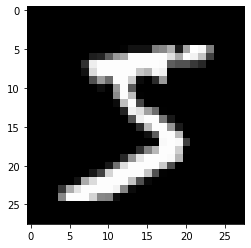

In [39]:
import numpy as np
import matplotlib.pyplot as plt

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train/255 - 0.5
x_train = x_train.astype('float32')
x_test = x_test/255 - 0.5
x_test = x_test.astype('float32')
#
print(y_train[0])
plt.imshow(x_train[0], cmap='gray', interpolation="nearest")

Let us define some constants that we be useful in the sequel

In [40]:
n = x_train.shape[0]
d_x = x_train.shape[1]
print(x_train.shape[1:])

(28, 28)


We can now begin to build the CNN. Following the explanations in the preamble, it seems like we need to turn the arrays of the dataset into `Tensor` instances. That won't be explicitely necessary because `TensorFlow` will do that on its own. So we can readily define a firt convoluational layer that we will connect to the array `x_train`. 

A second point to mention is that we will use high level functions in this practical session, i.e. functions that in reality translate in multiple nodes of the graph. These functions and classes belong to the `Keras` API. It is accessiable through `tf.Keras`. Note that the backend of this API is `TensorFlow` itself !! So using `Keras` somewhat shadows the use of the computation graph. However, we will see that building a model with `Keras` follows the same philosophy of piling up operations.

To use `Keras` functions, we need to prepare ourselves a little bit:
* by reshaping our input tensor as 4D tensor where the 4th and last dimension is 1. Later in the graph, this dimension will be larger because we will use multiple filters,
* by creating an instance from `tf.keras.Input` which is compatible with `x_train` and plays the role of "input layer" for a `Keras` model even if it does not contain actual data

### Q1
* Reshape `x_train` by adding a 4th dimension of size 1 to it. This dimension is referred to as "image channel".
* Fill the gap in the instantiation of `tf.keras.Input`. The `shape` parameter must receive a tuple containing image height, image width and image channels. This means that the dataset size is not passed to the constructor because `Keras` does not need this information to build a model.

## Réponse Q1

In [41]:
x_train = np.reshape(x_train,(n, d_x, d_x, 1))
inputs = tf.keras.Input(shape=(d_x, d_x, 1))

The next element of our NN is a 2D convolutional layer. We can use an instance of `tf.keras.layers.Conv2D` class. We need to specify the number of size of filters (kernels) that we want, what filter size, how to deal with image borders (padding) and what activation we would like. 

This layer is plugged to the input layer by passing it as input, as if `conv1` was also a function. This way of connecting `Keras` layers will be the same in the sequel.

This gives:

In [42]:
# Convolutional Layer #1
conv1 = tf.keras.layers.Conv2D(
      filters=64,
      kernel_size=[5, 5],
      padding="valid",
      activation=tf.nn.relu)(inputs)

Next, we need a pooling layer to give up some entries of the filtered images provided by the convolutional layer. We will use the usual max pool function in 2x2 neighborhoods which drops 3 entries out of 4 in each such neighborhood. The remaining entry is the one achieving maximal value in the neighborhood.

In [43]:
# Pooling Layer #1
pool1 = tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(conv1)

### Q2
* Why is `strides=2` the correct parameter value for our goal ? 
* What is the size of each feature map after max pooling ?
* How many feature maps are there ?

We will now plug a 1-layer-MLP on top of this. Fully connected layers (or dense layers) do not accept 4D tensors but 2D ones. We can use `tf.reshape` to flatten feature maps / images to vectors. In the following code the scalar `dflat` = nbr of feature maps x feature map width x feature map height. 

## Réponse Q2

- `strides=2` is the correct parameter because we would otherwise be revisiting pixels for each max pooling operation, which would not drop coefficients.
- After filtering, using the formula "`d_x - kernel_size + 1 = 28 - 5 + 1 = 24`" we can determine that each feature map is of size `(24,24)`. After max pooling, it then becomes size `(12,12)` because of the stride of 2.
- There are `64` feature maps in total, which corresponds to the number of filters used during convolution.

### Q3
* Set this variable with the correct value and execute the following code line: 

## Réponse Q3

In [44]:
dflat = 12 * 12 * 64
pool2_flat = tf.reshape(pool1, [-1, dflat])
pool2_flat.shape

TensorShape([None, 9216])

Now the first layer MLP is given by an instance of `tf.keras.layers.Dense` as:

In [45]:
mlp = tf.keras.layers.Dense(units=1024, activation=tf.nn.relu)(pool2_flat)

Finally, we need a softmax layer to obtain class membership probabilities. This can be done in this way:

In [46]:
logits = tf.keras.layers.Dense(units=10)(mlp)
smax = tf.keras.layers.Softmax()(logits)
model = tf.keras.Model(inputs=inputs, outputs=smax)


Next, we need to compile the `Keras` model. During this operation, we give the desired values for remaining hyperparameters. We also specify a loss, which in our case is cross-entropy. 

After compiling, `Keras` allows to have an overview of the model by invoking the `summary` function. This shows us how many parameters there are per layer. 

### Q4
* Explain these numbers layer per layer.


## Réponse Q4
- `input_2` : `(28,28,1)` $\implies$ Each image is of size 28 x 28, with only 1 channel (greyscale). There are no parameters in this layer.
    
- `conv2d_1` : `(24,24,64)` $\implies$ It is a convolution layer with 64 filters, and we previously explained why the output shape is as such. The number of parameters is `64 x (shape of filters) x (number of filters) + (number of intercepts) = 64 x 5 x 5 + 64 = 1664`.
- `max_pooling2d` : `(12,12,64)` $\implies$ It is a max pooling layer with a stride of 2, which halves the width and height of the feature maps (but doesn't change their number, 64). There are no parameters for this layer.
-  `tf.reshape_7` : `(9216)` $\implies$ The output of the previous layer is completely flattened, which means that we concatenate all the dimensions, hence the size of ``12 x 12 x 64 = 9216``.
-  `dense_1` : `(1024)` $\implies$ It is an MLP that returns an output of shape 1024 feature maps (which is purely a choice). The number of parameters is `9216 x 1024 + 1024 = 9438208`.
-   `dense_2` : `(10)` $\implies$ Another MLP, but this time the size of the output is significant: there are 10 classes (10 numbers to guess from), so the output of this last MLP must be of size 10. The number of parameters is `1024 x 10 + 10 = 10250`.
-   `softmax` : `(10)` $\implies$ The activation layer, which makes the output of the previous MLP bound between 0 and 1, which can then be interpreted as the probabilities to belong to each of the 10 classes.

In [47]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy(),])
model.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 24, 24, 64)        1664      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 tf.reshape_14 (TFOpLambda)  (None, 9216)              0         
                                                                 
 dense_41 (Dense)            (None, 1024)              9438208   
                                                                 
 dense_42 (Dense)            (None, 10)                10250     
                                                          

One of greatest feature of `Keras` is that the training loop is directly implemented through the `fit` function of our model. Let us start training our model for 2 epochs

In [48]:
model.fit(x=x_train, y=tf.keras.utils.to_categorical(y_train), batch_size=20, epochs=2) 

Epoch 1/2
3000/3000 [==============================] - 227s 75ms/step - loss: 0.1073 - categorical_accuracy: 0.9671
Epoch 2/2
3000/3000 [==============================] - 213s 71ms/step - loss: 0.0402 - categorical_accuracy: 0.9870


To check that we did not overfit, we need to evaluate our model on the test set.

## Q5
* reshape `x_test` in a 4D tensor just like we did for `x_train`
* document yourself on the evaluate function of `tf.Keras.Model` and compute the model accuracy on the test set

## Réponse Q5

In [49]:
x_test = np.reshape(x_test,(len(x_test), d_x, d_x, 1))
loss, accuracy = model.evaluate(x = x_test, y=tf.keras.utils.to_categorical(y_test))

313/313 [==============================] - 4s 12ms/step - loss: 0.0386 - categorical_accuracy: 0.9870


In [50]:
print(f"On the test set, we reach a loss of {round(loss, 3)} with an accuracy of {round(accuracy, 3)}.")

On the test set, we reach a loss of 0.039 with an accuracy of 0.987.


### Q6
* Add a second pair of conv/pool layers. A smaller amount amount of filters and smaller filters are recommended.

### Q7
* Add a second fully connected layer. A smaller number of units is recommended.

## Réponses Q6 & Q7

In [51]:
# Input
inputs = tf.keras.Input(shape=(d_x, d_x, 1))

# Convolutional Layer #1
conv1 = tf.keras.layers.Conv2D(
      filters=64,
      kernel_size=[5, 5],
      padding="valid",
      activation=tf.nn.relu)(inputs)

# Pooling Layer #1
pool1 = tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(conv1)

# Convolutional Layer #2
conv2 = tf.keras.layers.Conv2D(
      filters=32,
      kernel_size=[3, 3],
      padding="valid",
      activation=tf.nn.relu)(pool1)

# Pooling Layer #2
pool2 = tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(conv2)

# Flatten
dflat = 5 * 5 * 32
pool3_flat = tf.reshape(pool2, [-1, dflat])

# First MLP
mlp1 = tf.keras.layers.Dense(units=1024, activation=tf.nn.relu)(pool3_flat)

# Second MLP
mlp2 = tf.keras.layers.Dense(units=64, activation=tf.nn.relu)(mlp1)

# Logits and Softmax
logits = tf.keras.layers.Dense(units=10)(mlp2)
smax = tf.keras.layers.Softmax()(logits)

# Building the model
new_model = tf.keras.Model(inputs=inputs, outputs=smax)

In [52]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy(),])
new_model.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 24, 24, 64)        1664      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 10, 10, 32)        18464     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 5, 5, 32)         0         
 g2D)                                                            
                                                                 
 tf.reshape_15 (TFOpLambda)  (None, 800)               0  

In [53]:
new_model.fit(x=x_train, y=tf.keras.utils.to_categorical(y_train), batch_size=20, epochs=2) 

Epoch 1/2
3000/3000 [==============================] - 57s 19ms/step - loss: 0.1106 - categorical_accuracy: 0.9663
Epoch 2/2
3000/3000 [==============================] - 62s 21ms/step - loss: 0.0442 - categorical_accuracy: 0.9865


We observe that adding another smaller convolution / max pool pair drastically reduces the number of parameters to learn (from 9 million to 900 thousands), which makes the learning much faster.

### Q8 (optional)
From the above NN architecture, try to tweak the other hyperparameters and comment on the sensitivity of the results wrt them. These latter include:
* the learning rate,
* the regularization strength (if regularization is activated),
* number of filters,
* filter sizes,
* activiation functions,
* strides,
* padding types,
* ...

## Réponse Q8

In [54]:
def reinitialize_model():
    # Input
    inputs = tf.keras.Input(shape=(d_x, d_x, 1))

    # Convolutional Layer #1
    conv1 = tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=[5, 5],
        padding="valid",
        activation=tf.nn.relu)(inputs)

    # Pooling Layer #1
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(conv1)

    # Convolutional Layer #2
    conv2 = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=[3, 3],
        padding="valid",
        activation=tf.nn.relu)(pool1)

    # Pooling Layer #2
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(conv2)

    # Flatten
    dflat = 5 * 5 * 32
    pool3_flat = tf.reshape(pool2, [-1, dflat])

    # First MLP
    mlp1 = tf.keras.layers.Dense(units=1024, activation=tf.nn.relu)(pool3_flat)

    # Second MLP
    mlp2 = tf.keras.layers.Dense(units=64, activation=tf.nn.relu)(mlp1)

    # Logits and Softmax
    logits = tf.keras.layers.Dense(units=10)(mlp2)
    smax = tf.keras.layers.Softmax()(logits)
    
    return inputs, smax

## Influence of learning rate

Let's try to train the model with a very low and a very high learning rate.

In [55]:
# Low learning rate: 1e-8
lr = 1e-8
inputs, smax = reinitialize_model()
model_low_lr = tf.keras.Model(inputs=inputs, outputs=smax)
model_low_lr.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=[tf.keras.metrics.CategoricalAccuracy(),])
model_low_lr.fit(x=x_train, y=tf.keras.utils.to_categorical(y_train), batch_size=20, epochs=2) 
loss, accuracy = model_low_lr.evaluate(x = x_test, y=tf.keras.utils.to_categorical(y_test))
print(f"With a learning rate of {lr}, we reach a loss of {round(loss, 3)} with an accuracy of {round(accuracy, 3)}.")

Epoch 1/2
3000/3000 [==============================] - 61s 20ms/step - loss: 2.3025 - categorical_accuracy: 0.0661
Epoch 2/2
313/313 [==============================] - 2s 6ms/step - loss: 2.3003 - categorical_accuracy: 0.0788
With a learning rate of 1e-08, we reach a loss of 2.3 with an accuracy of 0.079.


In [56]:
# High learning rate: 1e-1
lr = 1e-1
inputs, smax = reinitialize_model()
model_high_lr = tf.keras.Model(inputs=inputs, outputs=smax)
model_high_lr.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=[tf.keras.metrics.CategoricalAccuracy(),])
model_high_lr.fit(x=x_train, y=tf.keras.utils.to_categorical(y_train), batch_size=20, epochs=2) 
loss, accuracy = model_high_lr.evaluate(x = x_test, y=tf.keras.utils.to_categorical(y_test))
print(f"With a learning rate of {lr}, we reach a loss of {round(loss, 3)} with an accuracy of {round(accuracy, 3)}.")

Epoch 1/2
3000/3000 [==============================] - 63s 21ms/step - loss: 3.8805 - categorical_accuracy: 0.1018
Epoch 2/2
313/313 [==============================] - 3s 8ms/step - loss: 2.3143 - categorical_accuracy: 0.0982
With a learning rate of 0.1, we reach a loss of 2.314 with an accuracy of 0.098.


With a low or a high learning rate, the accuracy of the model is very poor: either the gradient descent doesn't converge towards the solution, or it converges so fast that it doesn't have the time to find the right descent direction, resulting in poor results in both cases.

## Influence of the number of filters
Let's try a low number of filters, to compare it with the results we obtained earlier (the number of filters being fairly high).

In [57]:
## 16 filters for the first convolutional layer, 8 for the second

# Input
inputs = tf.keras.Input(shape=(d_x, d_x, 1))

# Convolutional Layer #1
conv1 = tf.keras.layers.Conv2D(
      filters=16,
      kernel_size=[5, 5],
      padding="valid",
      activation=tf.nn.relu)(inputs)

# Pooling Layer #1
pool1 = tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(conv1)

# Convolutional Layer #2
conv2 = tf.keras.layers.Conv2D(
      filters=8,
      kernel_size=[3, 3],
      padding="valid",
      activation=tf.nn.relu)(pool1)

# Pooling Layer #2
pool2 = tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(conv2)

# Flatten
dflat = 5 * 5 * 8
pool3_flat = tf.reshape(pool2, [-1, dflat])

# First MLP
mlp1 = tf.keras.layers.Dense(units=1024, activation=tf.nn.relu)(pool3_flat)

# Second MLP
mlp2 = tf.keras.layers.Dense(units=64, activation=tf.nn.relu)(mlp1)

# Logits and Softmax
logits = tf.keras.layers.Dense(units=10)(mlp2)
smax = tf.keras.layers.Softmax()(logits)

# Building the model
model_low_filters = tf.keras.Model(inputs=inputs, outputs=smax)

model_low_filters.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy(),])
model_low_filters.summary()

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_34 (Conv2D)          (None, 24, 24, 16)        416       
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 12, 12, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 10, 10, 8)         1160      
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 5, 5, 8)          0         
 g2D)                                                            
                                                                 
 tf.reshape_18 (TFOpLambda)  (None, 200)               0  

In [58]:
model_low_filters.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=[tf.keras.metrics.CategoricalAccuracy(),])
model_low_filters.fit(x=x_train, y=tf.keras.utils.to_categorical(y_train), batch_size=20, epochs=2) 
loss, accuracy = model_low_filters.evaluate(x = x_test, y=tf.keras.utils.to_categorical(y_test))
print(f"With a low number of filter, we reach a loss of {round(loss, 3)} with an accuracy of {round(accuracy, 3)}.")

Epoch 1/2
3000/3000 [==============================] - 22s 7ms/step - loss: 0.1361 - categorical_accuracy: 0.9572
Epoch 2/2
313/313 [==============================] - 1s 4ms/step - loss: 0.0392 - categorical_accuracy: 0.9873
With a low number of filter, we reach a loss of 0.039 with an accuracy of 0.987.


We can observe that lowering the number of filters doesn't have much of an impact on the accuracy, but it makes the learning process much faster (number of parameters divided by 4). Indeed, in this example, the images are quite small and the shapes to distinguish not that complex, so there is no need for a very high number of filters. However for a more complex problem, it would probably reduce the accuracy of the model.

### Q9
* Compare the obtained accuracy to that of a regularized Softmax regression from `sklearn`.

In [73]:
from sklearn.linear_model import SGDClassifier

# loading data
(x_train_sk, y_train_sk), (x_test_sk, y_test_sk) = mnist.load_data()

# flattening the image
x_train_sk = x_train_sk.reshape(x_train_sk.shape[0], -1)

# fitting the regularized softmax regression
classifier = SGDClassifier()
classifier.fit(X=x_train_sk, y=y_train_sk)

SGDClassifier()

In [75]:
from sklearn.metrics import accuracy_score

# flattening the image
x_test_sk = x_test_sk.reshape(x_test_sk.shape[0], -1)

# evaluating on the test set
accuracy = accuracy_score(y_true = y_test_sk, y_pred = classifier.predict(x_test_sk))

print(f"With a regularized softmax regression, we reach an accuracy of {round(accuracy, 3)}.")

With a regularized softmax regression, we reach an accuracy of 0.867.


The accuracy is significantly lower using a regularized softmax regression compared to the convolutional network, for a comparable training time. It shows the efficiency of convolutional networks for this type of image classification: it extracts better and more relevant features.